# MESA Ecospatial Tutorials 

In [1]:
import numpy as np
import anndata as ad
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.figure import figaspect

from mesa import ecospatial as eco

OMP: Info #270: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/opt/miniconda3/envs/mesa_test/lib/python3.10/site-packages/spaghetti/network.py:42: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)


In [2]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['svg.fonttype'] = 'none'  # To keep text as text in SVGs

## Read Data

In [3]:
adata = ad.read_h5ad('/Users/Emrys/Dropbox/spatial_augmentation/data/codex_mouse_spleen/codex_mouse_spleen.h5ad')
adata.obsm['spatial'] = adata.obsm['spatial']/1000 # Convert units to microns

## Perform Ecospatial Analysis on one sample

In [4]:
# Define sample 
sample_id = 'MRL-8'

# Generate Quardrats
patches_coordinates = eco.generate_patches(spatial_data=adata,
                                           library_key='sample',
                                           library_id=sample_id,
                                           scaling_factor=64.,
                                           spatial_key='spatial')

In [5]:
# Calculate MDI
## Define the sequence of scales
scales = [1., 2., 4., 8., 16., 32., 64.]

df_entropy, df_slopes = eco.multiscale_diversity(spatial_data=adata,
                                                 scales=scales,
                                                 library_key='sample',
                                                 library_ids=[sample_id],
                                                 spatial_key='spatial',
                                                 cluster_key='cell_type',
                                                 random_patch=False,
                                                 plotfigs=False,
                                                 savefigs=False,
                                                 patch_kwargs={'random_seed': None, 'min_points':2},
                                                 other_kwargs={'metric': 'Shannon Diversity'})

Processing region: MRL-8 at scale 1.0
0.000 per cent patches are empty
MRL-8 at scale 1.0 has 0 patches with zero diveristy
MRL-8 at scale 1.0 diversity is 3.4656779602794114
Processing region: MRL-8 at scale 2.0
0.000 per cent patches are empty
MRL-8 at scale 2.0 has 0 patches with zero diveristy
MRL-8 at scale 2.0 diversity is 3.292377010141359
Processing region: MRL-8 at scale 4.0
0.000 per cent patches are empty
MRL-8 at scale 4.0 has 0 patches with zero diveristy
MRL-8 at scale 4.0 diversity is 3.0901648127096593
Processing region: MRL-8 at scale 8.0
0.000 per cent patches are empty
MRL-8 at scale 8.0 has 0 patches with zero diveristy
MRL-8 at scale 8.0 diversity is 2.8661607204492103
Processing region: MRL-8 at scale 16.0
0.000 per cent patches are empty
MRL-8 at scale 16.0 has 0 patches with zero diveristy
MRL-8 at scale 16.0 diversity is 2.631288636532884
Processing region: MRL-8 at scale 32.0
0.000 per cent patches are empty
MRL-8 at scale 32.0 has 0 patches with zero diverist

In [6]:
print(f"MDI: {df_slopes[sample_id].values[0]:.3f}")

MDI: 0.256


0.098 per cent patches are empty


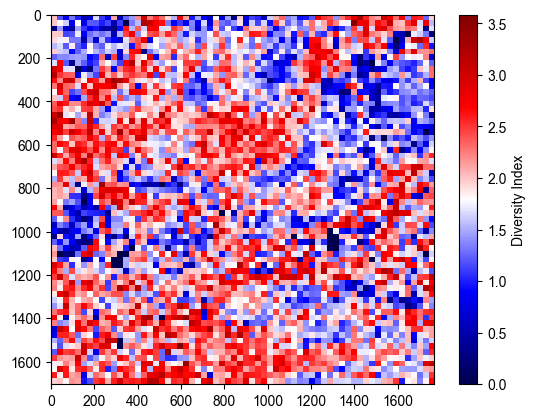

In [7]:
# Caculate Shannon Diversity Index for each quadrat
patch_indices, patches_comp = eco.calculate_diversity_index(spatial_data=adata, 
                                                            library_key='sample', 
                                                            library_id=sample_id, 
                                                            spatial_key='spatial', 
                                                            patches=patches_coordinates, 
                                                            cluster_key='cell_type', 
                                                            metric='Shannon Diversity', return_comp=True)


# Visualize the diversity indices of quadrats
grid, heatmap_fig = eco.diversity_heatmap(spatial_data=adata,
                                          library_key='sample', 
                                          library_id=sample_id,
                                          spatial_key='spatial',
                                          patches=patches_coordinates, 
                                          heterogeneity_indices=patch_indices,
                                          tissue_only=False,
                                          plot=True,
                                          return_fig=True)

In [8]:
# Calculate GDI by applying global moran's I on the Diversity Heatmap
GDI, p_sim = eco.global_moran(grid, tissue_only=False, plot_weights=False)
print(f"GDI: {GDI:.3f}, p-value: {p_sim:.3f}")

GDI: 0.379, p-value: 0.001


In [9]:
# Calculate LDI and find hot/coldspots by applying local moran's I on the Diversity Heatmap
hotspots, coldspots, _, _ = eco.local_moran(grid, p_value=0.01, tissue_only=False)

width: 1768.140, height: 1704.784


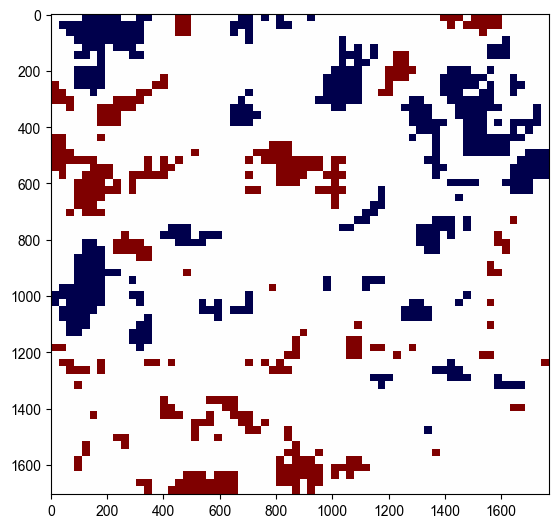

In [10]:
# Visualise hot/coldspot 
combined_spots = (hotspots * 1) + (coldspots * -1)
seismic = plt.cm.seismic
colors = [seismic(0), "white", seismic(0.999)]
cmap = mcolors.LinearSegmentedColormap.from_list("custom_map", colors)

spatial_value = adata[adata.obs['sample']==sample_id].obsm['spatial']
min_x, min_y = spatial_value.min(axis=0)[0], spatial_value.min(axis=0)[1]
max_x, max_y = spatial_value.max(axis=0)[0], spatial_value.max(axis=0)[1]
width = max_x - min_x
height = max_y - min_y
print(f"width: {width:.3f}, height: {height:.3f}")
w, h = figaspect(height/width)

spot_fig = plt.figure(figsize=(w, h))
ax = spot_fig.add_axes([0, 0, 1, 1])

# Create a 2D grid
grid = np.zeros((int(max_y - min_y + 1), int(max_x - min_x + 1)))

# Fill the grid with heterogeneity indices
for patch, diversity_index in enumerate(combined_spots.flatten()):
    x0, y0, x1, y1 = patches_coordinates[patch]
    grid[int(y0-min_y):int(y1-min_y+1), int(x0-min_x):int(x1-min_x+1)] = diversity_index

# Plot the heatmap
ax.imshow(grid, cmap=cmap, interpolation='none', vmin=-1, vmax=1)

In [ ]:
# Calculate DPI for hotspots
Hot = True 
proximity_I = eco.island_proximity(spatial_data=adata, 
                                   scale=64.0, 
                                   library_key='sample',
                                   library_ids=[sample_id], 
                                   spatial_key='spatial',
                                   cluster_key='cell_type',
                                   hotspot=Hot,
                                   metric='Shannon Diversity')
print(f"DPI: {proximity_I.get(sample_id)[0]:.3f}")

Processing region: MRL-8 at scale 64.0
